In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import time
import pyproj

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

RAW_DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen/cesm_lens/combined_data'

PROCESSED_DATA_DIRECTORY = '/scratch/users/yucli/cesm_data_processed'

MODEL_DIRECTORY = '/scratch/users/yucli/sicpred_models'

PREDICTIONS_DIRECTORY = '/scratch/users/yucli/sicpred_model_predictions'

# Renamed variable names 
VAR_NAMES = ["icefrac", "icethick", "temp", "geopotential", "psl", "lw_flux", "sw_flux", "ua"]


In [3]:
# icefrac_sample = xr.open_dataset(f"{RAW_DATA_DIRECTORY}/icefrac_combined.nc").icefrac.isel(member_id=0, time=0)
variables = ["icethick", "icefrac", "temp"]

samples = {}
for var in variables:
    samples[var] = xr.open_dataset(f"{RAW_DATA_DIRECTORY}/{var}_combined.nc")[var].isel(member_id=slice(0, 5))

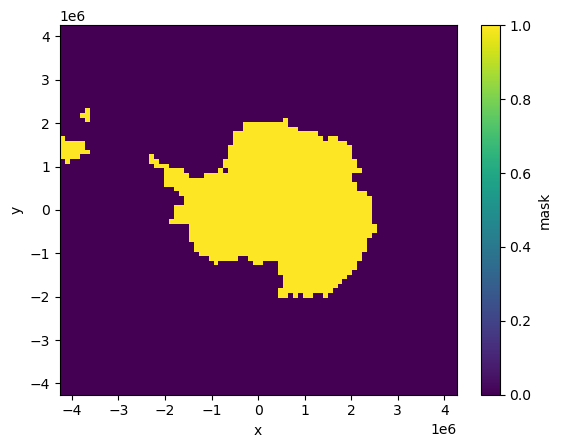

In [11]:
xr.open_dataset(f"{DATA_DIRECTORY}/cesm_lens/grids/icefrac_land_mask.nc").mask.plot()

In [19]:
dir = os.path.join(PROCESSED_DATA_DIRECTORY, "normalized_inputs", "simple_inputs")
xr.open_dataset(os.path.join(dir, f"icefrac_norm.nc"))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/yucli/cesm_data_processed/normalized_inputs/simple_inputs/icefrac_norm.nc'

In [2]:
def generate_empty_predictions_ds(reference_grid, time_coords, ensemble_members, max_lead_time, y_dim, x_dim):
    ds = xr.Dataset(
        {
            "predictions": (
                ["start_prediction_month", "member_id", "lead_time", "y", "x"],
                np.full((len(time_coords), len(ensemble_members), max_lead_time, y_dim, x_dim), np.nan, dtype=np.float32)
            )
        },
        coords={
            "start_prediction_month": time_coords,
            "member_id": ensemble_members,
            "lead_time": np.arange(1, max_lead_time+1),
            "y": reference_grid.y.values,
            "x": reference_grid.x.values,
        }
    )

    return ds 

def generate_sps_grid(grid_size=80, lat_boundary=-52.5):
    # Define the South Polar Stereographic projection (EPSG:3031)
    proj_south_pole = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-70)

    # Define the geographic coordinate system (EPSG:4326)
    proj_geographic = pyproj.Proj(proj='latlong', datum='WGS84')

    # Create a transformer object for forward (Stereographic to Geographic) transformations
    transformer = pyproj.Transformer.from_proj(proj_south_pole, proj_geographic, always_xy=True)

    # Compute the maximum radius from the South Pole in stereographic coordinates
    _, max_radius = proj_south_pole(0, lat_boundary)

    x = np.linspace(-max_radius, max_radius, grid_size)
    y = np.linspace(-max_radius, max_radius, grid_size)
    X, Y = np.meshgrid(x, y)

    # Transform coordinates to geographic (lat, lon) for the cell centers
    lon, lat = transformer.transform(X, Y)

    # Compute the edges (boundaries) of the grid cells
    x_edges = np.linspace(-max_radius, max_radius, grid_size + 1)
    y_edges = np.linspace(-max_radius, max_radius, grid_size + 1)
    X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

    # Transform the edges to geographic coordinates
    lon_edges, lat_edges = transformer.transform(X_edges, Y_edges)

    # Calculate grid cell areas
    geod = pyproj.Geod(ellps="WGS84")
    areas = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            # Define the four corners of the grid cell using edges
            lons = [lon_edges[i, j], lon_edges[i + 1, j], lon_edges[i + 1, j + 1], lon_edges[i, j + 1]]
            lats = [lat_edges[i, j], lat_edges[i + 1, j], lat_edges[i + 1, j + 1], lat_edges[i, j + 1]]
            
            # Compute the polygon area
            area, _ = geod.polygon_area_perimeter(lons, lats)
            areas[i, j] = abs(area)  # Area might be negative due to polygon orientation

    # Create the output dataset
    output_grid = xr.Dataset(
        {
            "lat": (["y", "x"], lat),
            "lon": (["y", "x"], lon),
            "area": (["y", "x"], areas),
        },
        coords={
            "x": (["x"], x),
            "y": (["y"], y),
        }
    )

    return output_grid



In [ ]:
# TODO: test the dataloader and loss function 



In [4]:
DATA_CONFIG_NAME = "simple-inputs_small-dataset"

DATA_SPLIT_SETTINGS = {
    "name": DATA_CONFIG_NAME, 
    "split_by": "ensemble_member",
    "train": ["r10i1181p1f1", "r10i1231p1f1", "r10i1251p1f1", "r10i1281p1f1", \
              "r2i1231p1f1", "r5i1081p1f1", "r6i1231p1f1", "r5i1231p1f1"], 
    "val": ["r2i1021p1f1"],
    "test": ["r2i1301p1f1", "r6i1101p1f1"],
    "time_range": pd.date_range("1851-01", "2013-12", freq="MS"),
    "member_ids": None
}

anom_ds = anomaly_persistence(DATA_SPLIT_SETTINGS, "somtehing")

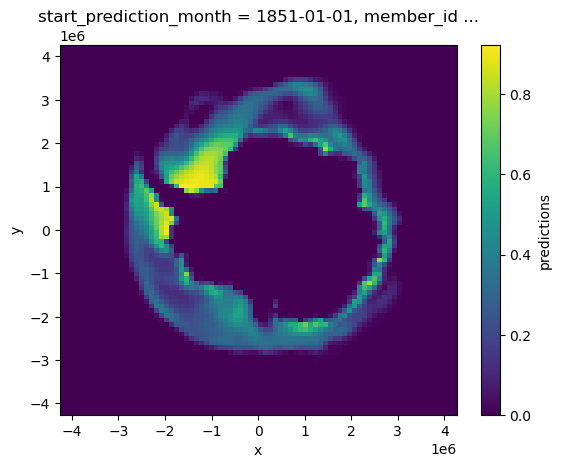

In [9]:
anom_ds.predictions.isel(member_id=0,start_prediction_month=0, lead_time=0).plot()

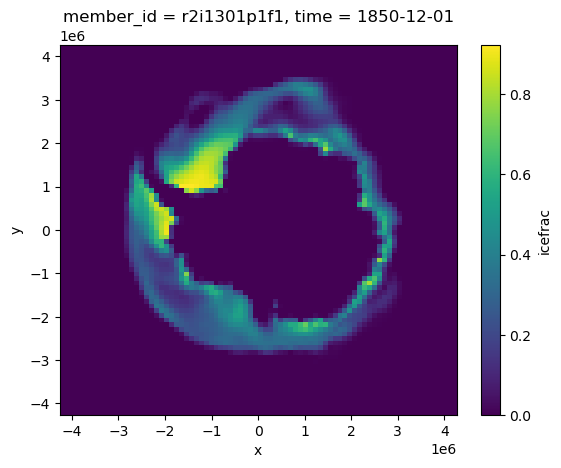

In [19]:
ds = xr.open_dataset(f"{RAW_DATA_DIRECTORY}/icefrac/icefrac_combined.nc")
time_coords = DATA_SPLIT_SETTINGS["time_range"] - pd.DateOffset(months=1)
icefrac_test_da = ds.icefrac.sel(time=time_coords, member_id=DATA_SPLIT_SETTINGS["test"])

ds_means = xr.open_dataset(f"{PROCESSED_DATA_DIRECTORY}/normalized_inputs/{DATA_SPLIT_SETTINGS["name"]}/icefrac_mean.nc")
da_means = ds_means.icefrac 

# compute the anomaly
months = icefrac_test_da['time'].dt.month
anom_da = icefrac_test_da - da_means.sel(month=months)
#da_means.sel(month=1).plot()

test_da = anom_da.isel(member_id=0, time=0) + da_means.sel(month=1)
test_da = test_da.clip(0,1)
test_da.plot()

In [19]:
clim_ds = climatology(DATA_SPLIT_SETTINGS, "something")
#xr.open_dataset(f"{RAW_DATA_DIRECTORY}/icefrac/icefrac_combined.nc")

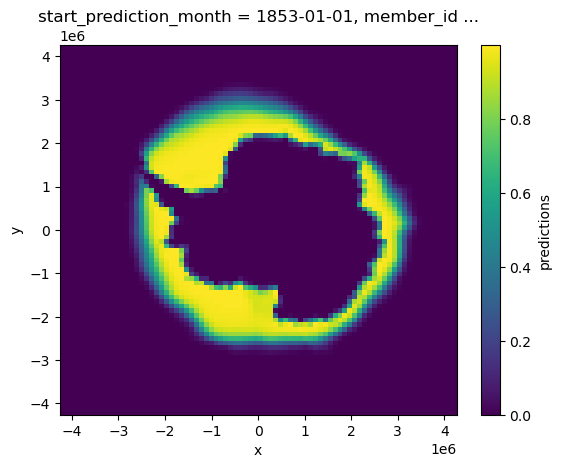

In [30]:
clim_ds.predictions.isel(member_id=0, start_prediction_month=24, lead_time=4)